#  MLP网络可视化 

**目标：**


1.   学习神经网络在训练过程中，隐含层的特征变化机制

代码中的学习器为多层感知机(multi layer perception, mlp)


**参考：**

葛家驿,杨乃森,唐宏,徐朋磊,纪超.端到端的梯度提升网络分类过程可视化[J].信号处理,2022,38(02):355-366.DOI:10.16798/j.issn.1003-0530.2022.02.015.

## 研究准备

### **环境配置**


In [ ]:
'''
全连接网络分类过程可视化
'''
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.callbacks import CSVLogger
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import ListedColormap
from matplotlib import cm
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_circles #同心圆数据
from sklearn.model_selection import train_test_split
import sys
sys.setrecursionlimit(500000)
import imageio
%pylab inline 


Populating the interactive namespace from numpy and matplotlib


### **设置模拟数据**

In [ ]:
n_samples = 1000 #样本点数
X, y = make_circles(n_samples=1000,factor=.4,noise=.06,random_state=0) #生成同心圆数据
test_size = 0.5

#划分训练集、测试集
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=test_size, random_state=2)

c,r = np.mgrid[[slice(X.min()- .2,X.max() + .2,50j)]*2]
p = np.c_[c.flat,r.flat]

ss = StandardScaler().fit(X_train)
X = ss.transform(X)
p = ss.transform(p)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

### **配置绘图环境**

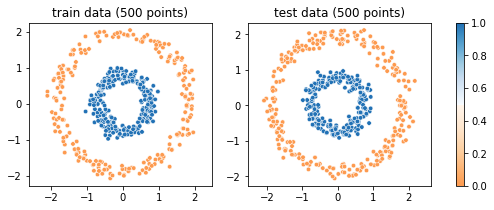

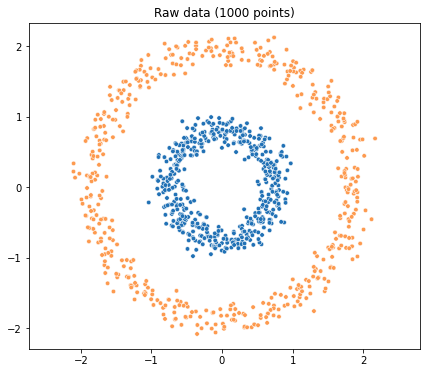

In [ ]:
#设置画布大小和颜色
fig = plt.figure(figsize = (9,3))
top = cm.get_cmap('Oranges_r', 512)
bottom = cm.get_cmap('Blues', 512)
newcolors = np.vstack((top(np.linspace(0.55, 1, 512)),
                       bottom(np.linspace(0, 0.75, 512))))
cm_bright = ListedColormap(newcolors, name='OrangeBlue')

#训练数据可视化
plt.subplot(121)
m1 = plt.scatter(*X_train.T,c = Y_train,cmap = cm_bright,edgecolors='white',s = 20,linewidths = 0.5)
plt.title(f'train data ({int(n_samples*(1-test_size))} points)')
plt.axis('equal')

#测试数据可视化
plt.subplot(122)
m2 = plt.scatter(*X_test.T,c = Y_test,cmap = cm_bright,edgecolors='white',s = 20,linewidths = 0.5);
plt.title(f'test data ({int(n_samples*test_size)} points)')
plt.axis('equal')
ax = fig.get_axes()
plt.colorbar(ax = ax)
#plt.savefig(f'data_{n_samples}_points.png')
#plt.savefig(f'data_{n_samples}_points.pdf')
plt.show()

#全部数据可视化
fig = plt.figure(figsize = (7,6))
plt.scatter(*X.T,c = y,cmap = cm_bright,edgecolors='white',s = 20,linewidths = 0.5)
plt.title(f'Raw data ({n_samples} points)')
plt.axis('equal')
#plt.savefig(f'Raw data ({n_samples} points)')
#plt.savefig(f'Raw data ({n_samples} points).pdf')
plt.axis('equal')
#plt.colorbar(ax = ax)
plt.show()

### **配置数据与损失函数**

In [ ]:
num_classes=2 #设置类别数
y_train=keras.utils.to_categorical(Y_train,num_classes) #类别标签转换为onehot编码
y_test=keras.utils.to_categorical(Y_test,num_classes)
#定义损失曲线绘制函数

def plot_loss_accuracy(history, title_text, file_name):

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy")
    ax2.set_ylabel("Loss")
    
    #ax1.set_ylim(-0.01,1.01)
    ax1.plot(history.epoch,
             history.history['accuracy'],
             label="Training Accuracy")
    ax1.plot(history.epoch,
             history.history['val_accuracy'],
             linestyle='--',
             label="Test Accuracy")
    
    #ax2.set_ylim(-0.01,1.01)
    ax2._get_lines.prop_cycler = ax1._get_lines.prop_cycler 
    
    ax2.plot(history.epoch, 
             history.history['loss'], 
             label="Training Loss")
    ax2.plot(history.epoch,
             history.history['val_loss'],
             linestyle='--',
             label="Test Loss")

    ax1.legend()
    ax2.legend()
    plt.suptitle(title_text)
    plt.savefig(file_name)

### **配置全连接模型**

In [ ]:
#定义全连接层

def FullyConnected_layers(number_of_layers,
                         num_neurons_of_layer,
                         inputs):
    x = inputs
    for n in range(number_of_layers):
        x = layers.Dense(num_neurons_of_layer,
                         activation=tf.nn.relu,
                         name = f'{n}th-hidden')(x)
#         #可选加入线性变换层并对该层的输出进行可视化
#         x = layers.Dense(num_neurons_of_layer,
#                          name = f'{n}th-linear')(x)
    return x

#构建全连接网络
def FullyConnected_Model(number_of_layers,num_neurons_of_layer):
    inputs = keras.Input(shape=(2, ))
    x = FullyConnected_layers(number_of_layers=number_of_layers,num_neurons_of_layer=num_neurons_of_layer,inputs=inputs)
    #outputs = layers.Activation('softmax')(x)
    outputs = layers.Dense(2, activation='softmax',name = 'activation')(x)
    
    Fully_Model = keras.Model(inputs, outputs)
    Fully_Model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adam(lr=3e-4),
                      metrics=['accuracy'])
    #csv_logger = CSVLogger(f'training_fully_model.log')
    history = Fully_Model.fit(X_train,
                        y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=2,
                        validation_data=(X_test, y_test))
    return Fully_Model,history

## 进行实验

### **设置训练参数**

In [ ]:
#设置参数

epochs=100 #迭代次数
batch_size=32 #batchsize
number_of_layers=4 #隐层数
num_neurons_of_layer=2 #隐层的神经元数
Fully_Model,history=FullyConnected_Model(number_of_layers,num_neurons_of_layer)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
16/16 - 1s - loss: 0.7272 - accuracy: 0.5100 - val_loss: 0.6891 - val_accuracy: 0.4980 - 753ms/epoch - 47ms/step
Epoch 2/100
16/16 - 0s - loss: 0.7086 - accuracy: 0.5200 - val_loss: 0.6747 - val_accuracy: 0.4960 - 41ms/epoch - 3ms/step
Epoch 3/100
16/16 - 0s - loss: 0.6930 - accuracy: 0.5260 - val_loss: 0.6618 - val_accuracy: 0.5120 - 45ms/epoch - 3ms/step
Epoch 4/100
16/16 - 0s - loss: 0.6792 - accuracy: 0.5320 - val_loss: 0.6506 - val_accuracy: 0.5240 - 52ms/epoch - 3ms/step
Epoch 5/100
16/16 - 0s - loss: 0.6672 - accuracy: 0.5340 - val_loss: 0.6413 - val_accuracy: 0.5220 - 43ms/epoch - 3ms/step
Epoch 6/100
16/16 - 0s - loss: 0.6567 - accuracy: 0.5380 - val_loss: 0.6335 - val_accuracy: 0.5280 - 41ms/epoch - 3ms/step
Epoch 7/100
16/16 - 0s - loss: 0.6479 - accuracy: 0.5400 - val_loss: 0.6269 - val_accuracy: 0.5360 - 49ms/epoch - 3ms/step
Epoch 8/100
16/16 - 0s - loss: 0.6400 - accuracy: 0.5480 - val_loss: 0.6211 - val_accuracy: 0.5420 - 44ms/epoch - 3ms/step
Epoch 9/100
16

### **可视化结果**


#### **绘制训练曲线**



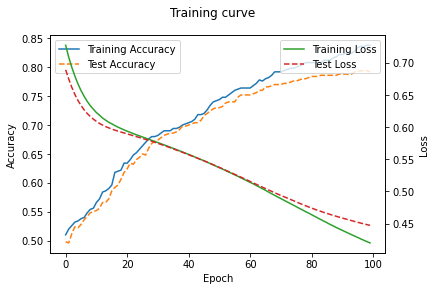

In [ ]:
#绘制训练曲线
plot_loss_accuracy(history,
                       f'Training curve',
                       f'Training curve.pdf')

#### **输出模型结构信息**

In [ ]:
#打印模型结构和参数信息
Fully_Model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 0th-hidden (Dense)          (None, 2)                 6         
                                                                 
 1th-hidden (Dense)          (None, 2)                 6         
                                                                 
 2th-hidden (Dense)          (None, 2)                 6         
                                                                 
 3th-hidden (Dense)          (None, 2)                 6         
                                                                 
 activation (Dense)          (None, 2)                 6         
                                                                 
Total params: 30
Trainable params: 30
Non-trainable params: 0

#### **对原始特征空间剖分的可视化**

79/79 [==============================] - 0s 2ms/step


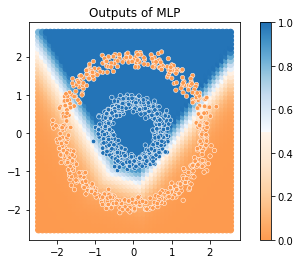

In [ ]:
#对原始特征空间剖分的可视化

prob = Fully_Model.predict(p)[:,1]
fig, ax1= plt.subplots(1,1, figsize=(7, 4),subplot_kw = {'aspect':'equal'})
ax1.scatter(*p.T,c = prob,cmap = cm_bright)
mp = ax1.scatter(*X.T,c = y,cmap = cm_bright,edgecolors='white',s = 20,linewidths = 0.5)
plt.colorbar(mp,ax = [ax1])
plt.title(f'Outputs of MLP')
plt.savefig(f'空间剖分结果.png')
plt.savefig(f'空间剖分结果.pdf')

#### **更换背景显示原始样本**

<Figure size 648x216 with 0 Axes>

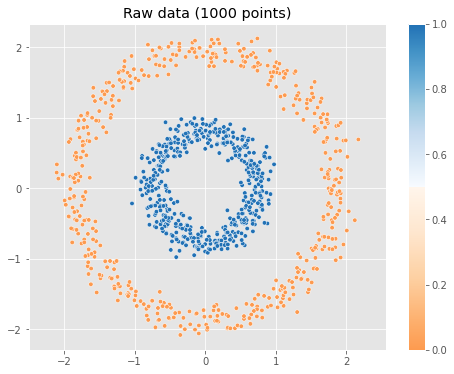

In [ ]:
#更换背景显示原始样本

mpl.style.use('ggplot')

fig = plt.figure(figsize = (9,3))
top = cm.get_cmap('Oranges_r', 512)
bottom = cm.get_cmap('Blues', 512)
newcolors = np.vstack((top(np.linspace(0.55, 1, 512)),
                       bottom(np.linspace(0, 0.75, 512))))
cm_bright = ListedColormap(newcolors, name='OrangeBlue')

fig = plt.figure(figsize = (8,6))
m3 = plt.scatter(*X.T,c = y,cmap = cm_bright,edgecolors='white',s = 20,linewidths = 0.5)
plt.title(f'Raw data ({n_samples} points)')
plt.axis('equal')
plt.colorbar()
plt.savefig(f'Raw data ({n_samples} points)')
plt.savefig(f'Raw data ({n_samples} points).pdf')
plt.axis('equal')
#plt.colorbar(ax = ax)
plt.show()

#### **特征变换过程可视化**

[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer '0th-hidden')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer '1th-hidden')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer '2th-hidden')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer '3th-hidden')>]


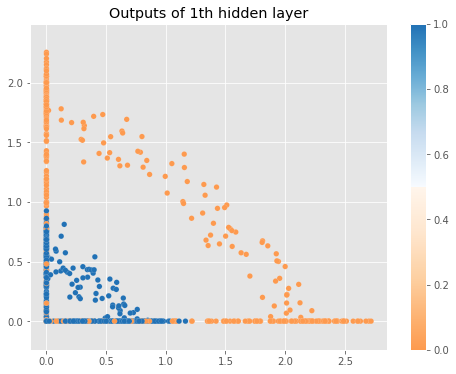

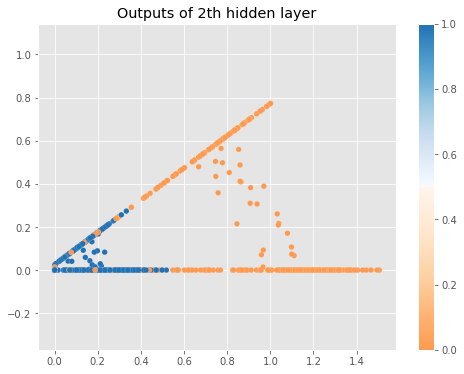

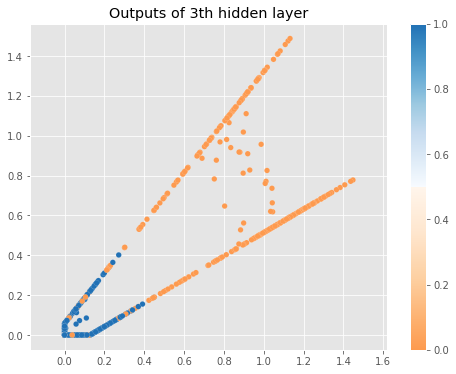

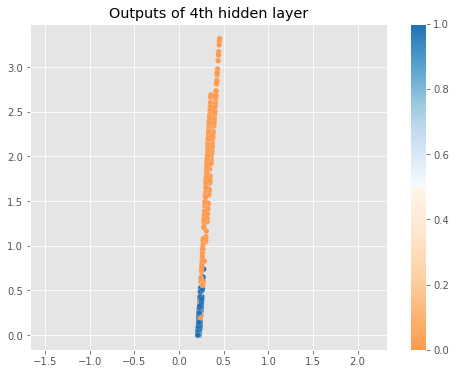

In [ ]:
#对样本点特征变换的可视化

hidden_layers = []
for i in range(number_of_layers):
    hidden_layer = Fully_Model.get_layer(f'{i}th-hidden')
    hidden_layers.append(hidden_layer)

inp = Fully_Model.input
outputs = [layer.output for layer in hidden_layers]
print(outputs)
functors = [K.function([inp], [out]) for out in outputs]
MLP_outs = [func([X]) for func in functors]

#可视化经过每一层隐层特征变换后样本点的状态
for idx in range(len(MLP_outs)):
    fig = plt.figure(figsize = (8,6))
    scatter(MLP_outs[idx][0][:,0],MLP_outs[idx][0][:,1],
            c = y,cmap = cm_bright,edgecolors='white',s = 30,linewidths = 0.1)
    plt.axis('equal')
    plt.title(f'Outputs of {idx+1}th hidden layer')
    plt.colorbar()
    plt.savefig(f'Outputs of {idx+1}th hidden layer.png')
    plt.savefig(f'Outputs of {idx+1}th hidden layer.pdf')
    plt.show()
    
#生成动图
def create_gif(image_list, gif_name, duration=1):
    frames = []
    for image_name in image_list:
        frames.append(imageio.imread(image_name))
    imageio.mimsave(gif_name, frames, 'GIF', duration=duration)
    return

def main():
    image_list = [f'Raw data ({n_samples} points).png']
    for i in range(len(MLP_outs)):
        image_list.append(f'Outputs of {i+1}th hidden layer.png')
    gif_name = '特征变换动图.gif'
    duration = 0.8
    create_gif(image_list, gif_name, duration)

main()